# 用tf-idf缩放数据

舍弃那些出现次数太多以至于没有信息量的单词。有两种主要方法:使用特定语言的停用词 (stopword)列表，或者舍弃那些出现过于频繁的单词。另一种方法是按照我们预计的特征信息量大小来缩放特征，而不是舍弃那些认为不重要的特征。最常见的一种做法就是使用**词频-逆向文档频率**(term frequency-inverse documenifrequency，tfid)方法。这一方法对在某个特定文档中经常出现的术语给予很高的权重，但对在语料库的许多文档中都经常出现的术语给予的权重却不高。如果一个单词在某个特定文档中经常出现，但在许多文档中却不常出现，那么这个单词很可能是对文档内容的很好描述。scikit-learn 在两个类中实现了t-idf 方法: TfidfTransformer 和TfidfVectorizer，前者接受CountVectorizer 生成的稀疏矩阵并将其变换，后者接受文本数据并完成词袋特征提取与 tf-idf 变换。tf-idf 缩放方案有几种变体)。单词w在文档d中的tf-idf分数在TfidfTransformer 类和TfidfVectorizer 类中都有实现，其计算公式如下所示:

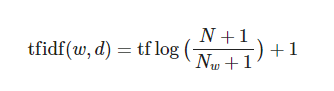

其中N是训练集中的文档数量，Nw是训练集中出现单词w的文档数量，tf(词频)是单词w在查询文档d(你想要变换或编码的文档) 中出现的次数。两个类在计算 tf-idf表示之后都还应用了L2 范数。换句话说，它们将每个文档的表示缩放到欧几里得范数为1。利用这种缩放方法，文档长度(单词数量)不会改变向量化表示。

由于tf-idf 实际上利用了训练数据的统计学属性，所以我们将使用在前面介绍过的管道，以确保网格搜索的结果有效。这样会得到下列代码:

In [1]:
from sklearn.datasets import load_files
import numpy as np
reviews_train = load_files("E:/clone/machine-learning/data/aclImdb/train/")
# load_files返回一个Bunch对象，其中包含训练文本和训练标签

data_array = np.array(reviews_train.data)
target_array = np.array(reviews_train.target)

# Filter out documents where the target is not equal to 2
labeled_indices = np.where(target_array != 2)[0]
text_train, y_train = data_array[labeled_indices], target_array[labeled_indices]
text_train = [doc.replace(b'<br />',b' ') for doc in text_train]

reviews_test = load_files("E:/clone/machine-learning/data/aclImdb/test/")
data_array = np.array(reviews_test.data)
target_array = np.array(reviews_test.target)
text_test, y_test = data_array, target_array
text_test = [doc.replace(b'<br />',b' ') for doc in text_test]

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=500))
param_grid = {"logisticregression__C" : [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation scores: {:.3f}".format(grid.best_score_))

Best cross-validation scores: 0.893


如你所见，使用 tf-idf 代替仅统计词数对性能有所提高。我们还可以查看 tf-idf 找到的最重要的单词。请记住，tf-idf 缩放的目的是找到能够区分文档的单词，但它完全是一种无监督技术。因此，这里的“重要”不一定与我们感兴趣的“正面评论”和“负面评论”标签相关。首先，我们从管道中提取 TfidfVectorizer:

In [3]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# best_estimator_：对象的此属性GridSearchCV提供在搜索过程中找到的性能最佳的估计器。
# named_steps：这是 scikit-learn 中管道的一个属性，它提供了一个类似字典的接口来访问管道中的各个步骤。
# "tfidfvectorizer"：这是您尝试访问的步骤的名称。
# 变换训练数据集
X_train = vectorizer.transform(text_train)
# 找到数据集中每个特征最大值
max_value = X_train.max(axis=0).toarray().ravel()
# ravel()是一种常用的将多维数组或矩阵转换为扁平化一维数组的方法。
# 这种方法通常应用于目标变量（y），以确保其表示为一维数组，这是许多机器学习算法的常见要求。
sorted_by_tfidf = max_value.argsort()
# argsort()函数返回对数组进行排序的索引。它用于沿指定轴执行间接排序，生成一个索引数组，可用于重建输入数组的排序版本。
# argsort()的结果是一个索引数组，可用于按排序顺序索引原始数组。
# 获取特征名称
feature_names = np.array(vectorizer.get_feature_names_out())

print("Features with lowest tfidf:\n{}\n".format(
      feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
      feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['suplexes' 'gauche' 'hypocrites' 'oncoming' 'songwriting' 'galadriel'
 'emerald' 'mclaughlin' 'sylvain' 'oversee' 'cataclysmic' 'pressuring'
 'uphold' 'thieving' 'inconsiderate' 'ware' 'denim' 'reverting' 'booed'
 'spacious']

Features with highest tfidf: 
['gadget' 'sucks' 'zatoichi' 'demons' 'lennon' 'bye' 'dev' 'weller'
 'sasquatch' 'botched' 'xica' 'darkman' 'woo' 'casper' 'doodlebops'
 'smallville' 'wei' 'scanners' 'steve' 'pokemon']


tf-idf 较小的特征要么是在许多文档里都很常用，要么就是很少使用，且仅出现在非常长的文档中。有趣的是，许多tf-idf 较大的特征实际上对应的是特定的演出或电影。这些术语仅出现在这些特定演出或电影的评论中，但往往在这些评论中多次出现。例如，对于pokemon"、"smallville”和“doodlebops"是显而易见的，但这里的"scanners"实际上指的也是电影标题。这些单词不大可能有助于我们的情感分类任务 (除非有些电影的评价可能普遍偏正面或偏负面)，但肯定包含了关于评论的大量具体信息

我们还可以找到逆向文档频率较低的单词，即出现次数很多，因此被认为不那么重要的单词。训练集的逆向文档频率值被保存在 idf_属性中:

In [4]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print("Features with lowest idf:\n{}".format(feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'one' 'be' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more' 'when'
 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really' 'story'
 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were' 'other'
 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how' 'great'
 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after' 'any'
 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen' 'its'
 'him']


正如所料，这些词大多是英语中的停用词，比如“the”和“no"。但有些单词显然是电影评论特有的，比如“movie"、"film"、"time"、"story"等。有趣的是，"good"、"great"和"bad”也属于频繁出现的单词，因此根据 tf-idf 度量也属于“不太相关”的单词，尽管我们可能认为这些单词对情感分析任务非常重要

# 研究模型系数¶

最后，我们详细看一下Logistic 回归模型从数据中实际学到的内容。由于特征数量非常多(删除出现次数不多的特征之后还有 27271个)，所以显然我们不能同时查看所有系数。但是，我们可以查看最大的系数，并查看这些系数对应的单词。我们将使用基于 tf-idf特征训练的最后一个模型。

下面这张条形图给出了 Logistic 回归模型中最大的25 个系数与最小的25个系数，其高度表示每个系数的大小:

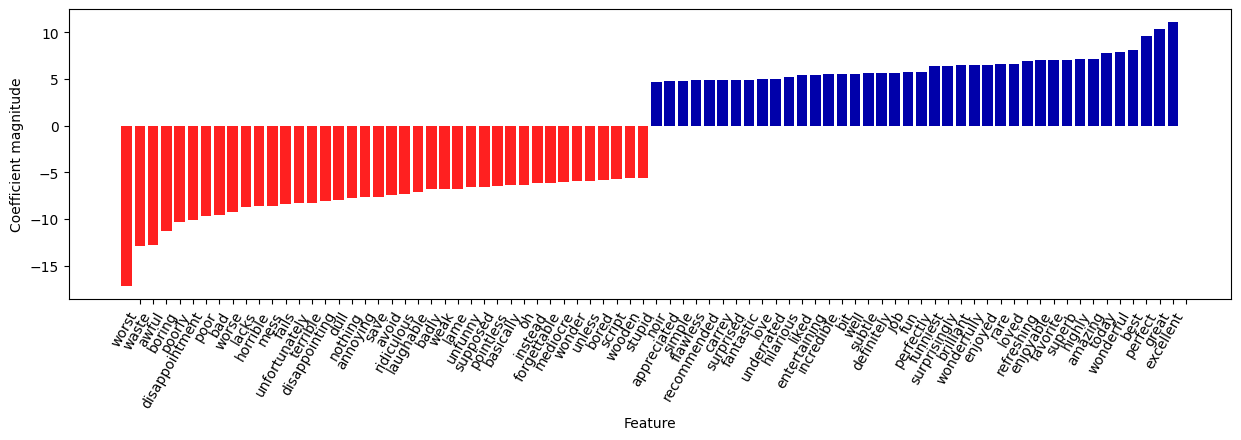

In [5]:
# 在tf-idf特征上训练的Logistic回归的最大系数和最小系数
import mglearn
mglearn.tools.visualize_coefficients(
    grid.best_estimator_.named_steps["logisticregression"].coef_,
    feature_names, n_top_features=40)

左侧的负系数属于模型找到的表示负面评论的单词，而右侧的正系数属于模型找到的表示正面评论的单词。大多数单词都是非常直观的，比如“worst”(最差)、"waste”(浪费)、"disappointment”(失望) 和“aughable”(可笑) 都表示不好的电影评论，而excellent”(优秀)、"wonderful"(精彩)、"enjoyable”(令人愉悦)和"refreshing(耳目一新)则表示正面的电影评论。有些词的含义不那么明确，比如“bit”(一点)"job”(工作)和"today”(今天)，但它们可能是类似"goodjob”(做得不错)和“besttoday”(今日最佳)等短语的一部分。